<a href="https://colab.research.google.com/github/awenroberts/QM2-Project/blob/main/Contingency%20accommodation%20and%20protest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sorting the number of protests into quarters


In [ ]:
import pandas as pd

df_2024 = pd.read_csv('2024 protest data.csv', encoding='latin1')
df_2025 = pd.read_csv('2025 protest data.csv', encoding='latin1')

df_protests = pd.concat([df_2024, df_2025])

df_protests['date'] = pd.to_datetime(df_protests['date'], format='%d/%m/%Y', errors='coerce')

df_protests_cleaned = df_protests.dropna(subset=['date'])

protest_quarterly = df_protests_cleaned.resample('QE', on='date').size().reset_index(name='protest_count')

protest_quarterly['quarter_id'] = protest_quarterly['date'].dt.to_period('Q').astype(str)

min_date = pd.to_datetime('2024-01-01')
max_date = protest_quarterly['date'].max()

full_quarter_range = pd.date_range(start=min_date, end=max_date, freq='QE')
full_quarter_df = pd.DataFrame({'date': full_quarter_range})
full_quarter_df['quarter_id'] = full_quarter_df['date'].dt.to_period('Q').astype(str)

protest_quarterly_full = pd.merge(full_quarter_df, protest_quarterly, on=['date', 'quarter_id'], how='left')
protest_quarterly_full['protest_count'] = protest_quarterly_full['protest_count'].fillna(0).astype(int)

print(protest_quarterly_full)

        date quarter_id  protest_count
0 2024-03-31     2024Q1              0
1 2024-06-30     2024Q2              0
2 2024-09-30     2024Q3             65
3 2024-12-31     2024Q4              0
4 2025-03-31     2025Q1              0
5 2025-06-30     2025Q2              5
6 2025-09-30     2025Q3             70
7 2025-12-31     2025Q4             14


Finding the share of people in contingency accomodation


In [ ]:
import pandas as pd

df_asylum = pd.read_csv('Asylum Seeker accommodation.csv', encoding='latin1', low_memory=False)

df_asylum['People'] = pd.to_numeric(df_asylum['People'], errors='coerce')

contingency_types = [
    'Contingency Accommodation - Hotel',
    'Contingency Accommodation - Other'
]

df_asylum['is_contingency'] = df_asylum['Accommodation Type'].isin(contingency_types)

total_supported_per_quarter = df_asylum.groupby('Year-Quarter')['People'].sum().reset_index(name='total_supported')

total_contingency_per_quarter = df_asylum[df_asylum['is_contingency'] == True].groupby('Year-Quarter')['People'].sum().reset_index(name='total_contingency')

asylum_grouped = pd.merge(total_supported_per_quarter, total_contingency_per_quarter, on='Year-Quarter', how='left')

asylum_grouped['total_contingency'] = asylum_grouped['total_contingency'].fillna(0)

asylum_grouped['contingency_share'] = (asylum_grouped['total_contingency'] / asylum_grouped['total_supported']) * 100

asylum_grouped['Year-Quarter'] = asylum_grouped['Year-Quarter'].str.replace(' ', '')

print(asylum_grouped[['Year-Quarter', 'total_supported', 'total_contingency', 'contingency_share']].to_string(index=False))

Year-Quarter  total_supported  total_contingency  contingency_share
      2024Q1         104299.0            37151.0          35.619709
      2024Q2         100995.0            32043.0          31.727313
      2024Q3         109024.0            38379.0          35.202341
      2024Q4         112187.0            41078.0          36.615651
      2025Q1         106771.0            34664.0          32.465744
      2025Q2         106075.0            34314.0          32.348810
      2025Q3         111651.0            38924.0          34.862205


Check if the Contingency share predicts the protest count

In [ ]:
import statsmodels.formula.api as smf

master_df = pd.merge(protest_quarterly_full, asylum_grouped, left_on='quarter_id', right_on='Year-Quarter')

model_contingency_share = smf.ols("protest_count ~ contingency_share", data=master_df).fit()


model_total_contingency = smf.ols("protest_count ~ total_contingency", data=master_df).fit()

print("\nOLS Regression Results (Protest Count vs. Contingency Share):")
print(model_contingency_share.summary())

print("\nOLS Regression Results (Protest Count vs. Total People in Contingency):")
print(model_total_contingency.summary())


OLS Regression Results (Protest Count vs. Contingency Share):
                            OLS Regression Results                            
Dep. Variable:          protest_count   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                 -0.088
Method:                 Least Squares   F-statistic:                    0.5122
Date:                Wed, 07 Jan 2026   Prob (F-statistic):              0.506
Time:                        15:48:46   Log-Likelihood:                -33.427
No. Observations:                   7   AIC:                             70.85
Df Residuals:                       5   BIC:                             70.75
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


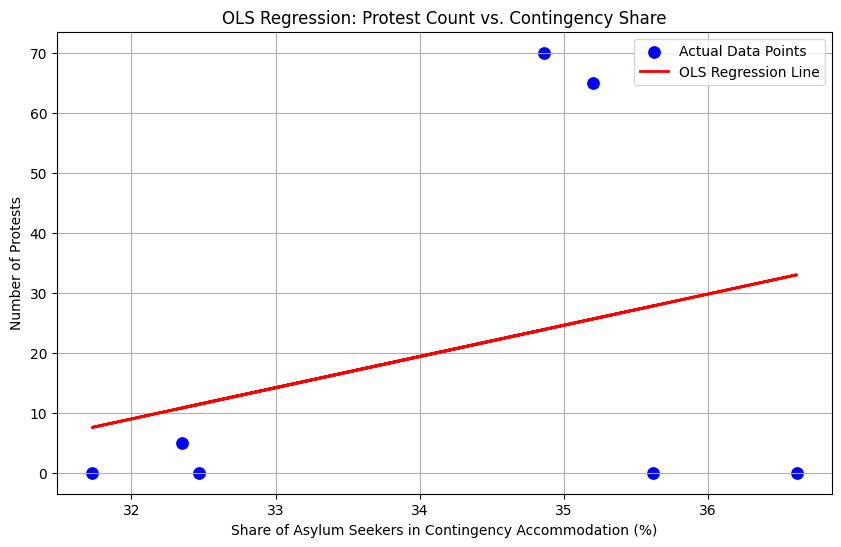

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='contingency_share', y='protest_count', data=master_df, s=100, color='blue', label='Actual Data Points')

plt.plot(master_df['contingency_share'], model_contingency_share.predict(master_df), color='red', linewidth=2, label='OLS Regression Line')

plt.title('OLS Regression: Protest Count vs. Contingency Share')
plt.xlabel('Share of Asylum Seekers in Contingency Accommodation (%)')
plt.ylabel('Number of Protests')
plt.legend()
plt.grid(True)
plt.show()

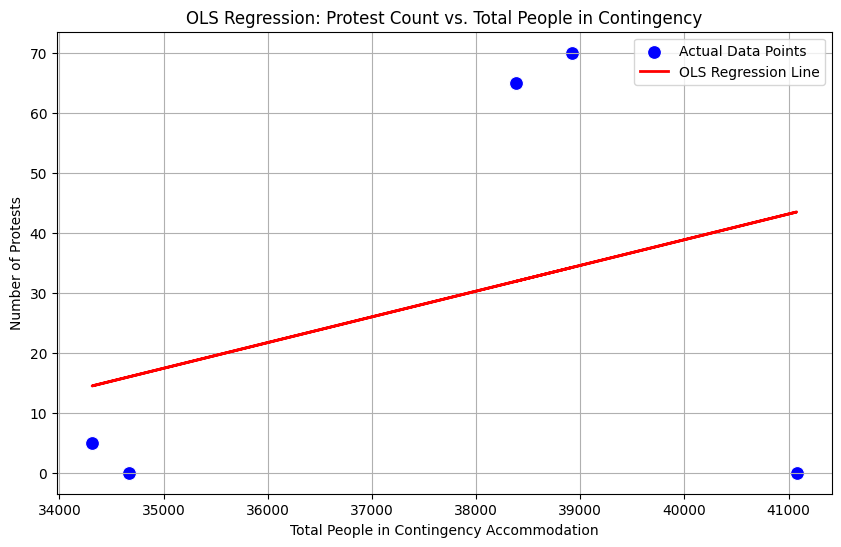

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x='total_contingency', y='protest_count', data=master_df, s=100, color='blue', label='Actual Data Points')

plt.plot(master_df['total_contingency'], model_total_contingency.predict(master_df), color='red', linewidth=2, label='OLS Regression Line')

plt.title('OLS Regression: Protest Count vs. Total People in Contingency')
plt.xlabel('Total People in Contingency Accommodation')
plt.ylabel('Number of Protests')
plt.legend()
plt.grid(True)
plt.show()

Final visualisation

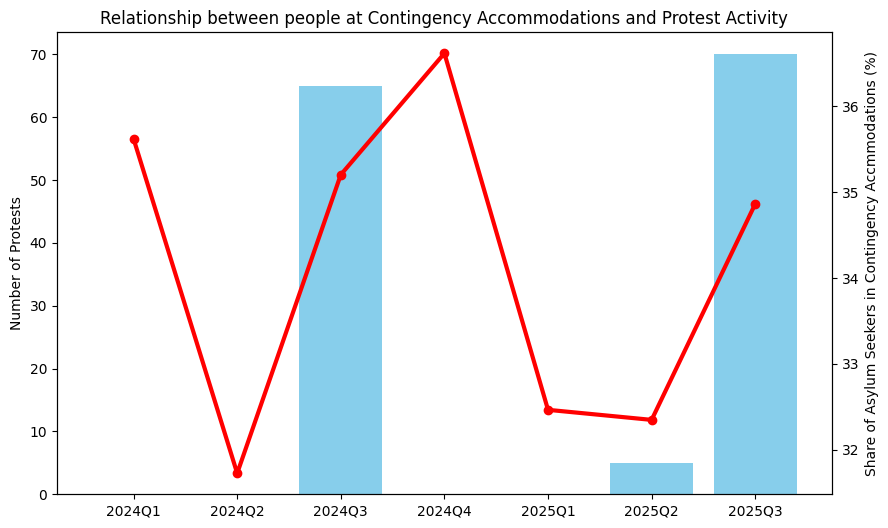

In [ ]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,6))

ax1.bar(master_df['quarter_id'], master_df['protest_count'], color='skyblue', label='Protest Count')
ax1.set_ylabel('Number of Protests')

ax2 = ax1.twinx()
ax2.plot(master_df['quarter_id'], master_df['contingency_share'], color='red', marker='o', linewidth=3, label='Contingency Share %')
ax2.set_ylabel('Share of Asylum Seekers in Contingency Accmmodations (%)')

plt.title('Relationship between people at Contingency Accommodations and Protest Activity')
plt.show()